In [2]:
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

C:\Users\Roshani\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_data_gen.flow_from_directory(
        'train',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = validation_data_gen.flow_from_directory(
        'test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

cv2.ocl.setUseOpenCL(False)

emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

C:\Users\Roshani\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [5]:
emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

C:\Users\Roshani\AppData\Local\Temp\ipykernel_27884\1151617337.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  emotion_model_info = emotion_model.fit_generator(


Epoch 1/50
448/448 [==============================] - 898s 2s/step - loss: 1.8072 - accuracy: 0.2581 - val_loss: 1.7135 - val_accuracy: 0.3292
Epoch 2/50
448/448 [==============================] - 237s 528ms/step - loss: 1.6375 - accuracy: 0.3559 - val_loss: 1.5529 - val_accuracy: 0.4042
Epoch 3/50
448/448 [==============================] - 241s 537ms/step - loss: 1.5387 - accuracy: 0.4092 - val_loss: 1.4844 - val_accuracy: 0.4314
Epoch 4/50
448/448 [==============================] - 250s 557ms/step - loss: 1.4632 - accuracy: 0.4377 - val_loss: 1.4279 - val_accuracy: 0.4604
Epoch 5/50
448/448 [==============================] - 679s 2s/step - loss: 1.3951 - accuracy: 0.4699 - val_loss: 1.3467 - val_accuracy: 0.4867
Epoch 6/50
448/448 [==============================] - 336s 750ms/step - loss: 1.3457 - accuracy: 0.4901 - val_loss: 1.3053 - val_accuracy: 0.5052
Epoch 7/50
448/448 [==============================] - 305s 680ms/step - loss: 1.2983 - accuracy: 0.5116 - val_loss: 1.2648 - val_a

In [6]:
model_json = emotion_model.to_json()
with open("emotion_model_video.json", "w") as json_file:
    json_file.write(model_json)

In [7]:
# save trained model weight in .h5 file
emotion_model.save_weights('emotion_model_video.h5')

In [8]:
import numpy as np
from keras.models import model_from_json
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

In [9]:
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}


In [10]:
json_file = open('emotion_model_video.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
emotion_model = model_from_json(loaded_model_json)

In [11]:
emotion_model.load_weights("emotion_model_video.h5")
print("Loaded model from disk")

Loaded model from disk


In [12]:
# Initialize image data generator with rescaling
test_data_gen = ImageDataGenerator(rescale=1./255)


In [13]:
# Preprocess all test images
test_generator = test_data_gen.flow_from_directory(
        'test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 7178 images belonging to 7 classes.


In [14]:
# do prediction on test data
predictions = emotion_model.predict_generator(test_generator)

C:\Users\Roshani\AppData\Local\Temp\ipykernel_27884\3003485560.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = emotion_model.predict_generator(test_generator)


[[112  12 125 245 203 140 121]
 [ 16   4  13  33  23  14   8]
 [141  19 135 256 203 138 132]
 [236  21 243 503 330 246 195]
 [171  12 175 342 237 160 136]
 [163  15 166 333 250 178 142]
 [ 96  10 122 241 146 109 107]]


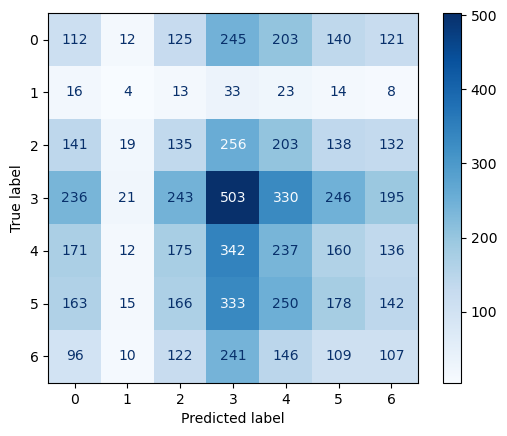

In [15]:
# confusion matrix
c_matrix = confusion_matrix(test_generator.classes, predictions.argmax(axis=1))
print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=emotion_dict)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()